# <span style='color:deepskyblue'> Cosmology MCMC notebook </span>

## <span style='color:deepskyblue'>Preliminaries</span>

In [665]:
# Install required packages (if not available on server)
!pip install getdist
import numpy as np
import matplotlib.pyplot as plt
import scipy.integrate as spi 
import pandas as pd
import requests
from io import StringIO

## <span style='color:deepskyblue'> The $\Lambda$CDM Model </span>

The Lambda-Cold-Dark-Matter ($\Lambda$CDM) Model is our concordance cosmological model. It postulates a Universe that behaves according to **General Relativity**, filled with **baryons** (protons, neutrons - the stuff we and stars are made of!), **Cold Dark Matter (CDM)** and a **Cosmological Constant** $\Lambda$.

The expansion of the Universe is best described in terms of the **scale factor** $a$ (the "radius" of the Universe, conventionally set to 1 today) and the **Hubble rate** $H$

$$
H \equiv \frac{\dot a}{a}
$$

The Einstein Equations in a **homogeneous, isotropic** Universe have an especially simple form and a special name, **Friedmann Equation**:

$$
H^2 = \frac{8\pi G}{3}\rho + \frac{k}{a^2}
$$

where $\rho$ is the total energy density of the Universe (at a certain time or size), and $k$ is a universal constant related to the [spatial curvature and shape of the Universe](https://en.wikipedia.org/wiki/Shape_of_the_universe#:~:text=The%20spatial%20curvature%20is%20related,indistinguishable%20spaces%20with%20different%20topologies.). In the $\Lambda$CDM model, this additionally simplifies to

$$
\boxed{
H^2 = H_0^2\left(\Omega_\Lambda + \Omega_m a^{-3} + \Omega_k a^{-2}\right)
}
\qquad
\qquad
\Omega_m + \Omega_\Lambda + \Omega_k = 1
$$

$H_0$ is the value of the Hubble rate *today*, and the parameters $\Omega_m$, $\Omega_\Lambda$ and $\Omega_k$ are dimensionless quantities indicating how much of the present expansion of the Universe is due to (non-relativistic) matter, cosmological constant $\Lambda$, and spatial curvature $k$. Note that the three $\Omega$'s are *not independent* (their sum is 1) and that we grouped together the contribution of baryons and CDM,

$$
\Omega_m = \Omega_{\rm CDM} + \Omega_{\rm b}
$$

and that we have evidence that independent evidence that $\Omega_b \approx 5$\%. Note that only $\Omega_m \geq 0$ makes physical sense, while in principle both $\Omega_\Lambda$ and $\Omega_k$ can be negative.

The present Hubble rate is conventionally parametrised in terms of the dimensionless $h$:

$$
H_0 \equiv h\,\frac{100 \text{km}}{\text{s Mpc}}
$$

where Mpc = Megaparsec and [parsec](https://en.wikipedia.org/wiki/Parsec) equals to about $3.26$ light years or $3.086 \cdot 10^{16}$ m. 

In essence, these equations give us the relation between *what exists in the Universe* and *how the Universe expanded*. Measure one, I can tell you the other. This is precisely what we aim to do!

Time to define the function $H(z)$. Don't forget to include the useful parameters as arguments of the function, and to define `parsec`.

In [666]:

PARSEC = 3.086*10**16 # Parsec in meters for easier use later in code
MPC = PARSEC * 10**6 # conversion of megaparsecs in meters 


#H_0 equation 
def H_0(h):     
    return h * (100000/MPC) # as H(z) for the Hubble parameter is dependent on H0

# Hubble rate
def Hubble(z,omega_lambda,omega_m,h):  # omega m r can be ignored in this instance  
    return H_0(h) * np.sqrt(omega_lambda + ((1 - omega_lambda - omega_m) * (1+z) **2) +omega_m * (1+z)**3) 

in this code box, as instructed I have:

1. defined the value of parsecc and megaparsec in meters 
2. i have defined the function H of 0 which is essential in other equations such as with the hubble rate equation
3. defined the hubble rate equation. To ease and simplify the hubble rate equation, omega k was calculated using the relation equaton of the different omega values, aka "omega_k = 1 - omega_lambda - omega_m". omega r is also not inccluded in the euqaiton as the value can be ignored in our instance, as mentioned in the presentation. 

##  <span style='color:deepskyblue'>Supernovae Ia</span>

In order to track the expansion of the Universe, we will look at Supernovae type Ia observations. SNIa are formed when a *white dwarf* accretes matter from a companion until it reaches a critical mass of about $1.44 M_\odot$ (solar masses), after which it explodes **at always the same luminosity** $L_{\rm SN}$. Therefore, the observed [magnitude](https://en.wikipedia.org/wiki/Magnitude_(astronomy)) is only a function of their [**luminosity distance**](https://en.wikipedia.org/wiki/Distance_measures_(cosmology)) from Earth, defined as the ratio of the intrinsic luminosity $L_{\rm SNIa}$ and the measured *surface brightness* $\Phi$ (energy per unit time per unit area)

$$ d_L\equiv \frac{L_{\rm SN}}{4\pi \Phi} $$

While photons (light rays) travel from the distant SNIa to Earth, the Universe expands and the photons get redshifted, and this redshift is directly related to the size of the Universe when the photon was emitted compared to today:

$$ \frac{\lambda_{\rm obs}}{\lambda_{\rm em}} \equiv 1 + z_{\rm em} = \frac{1}{a_{\rm em}}$$

We can express the luminosity distance in terms of the Hubble rate:

$$ 
\boxed{
d_L(z) = \frac{c}{H_0}(1+z) \times 
\begin{cases}
    \cfrac{1}{\sqrt{\Omega_k}} \sinh\left(\sqrt{\Omega_k}D(z)\right) & \Omega_k > 0
    \\[.5em]
    D(z) & \Omega_k = 0
    \\[.5em]
    \cfrac{1}{\sqrt{-\Omega_k}} \sin\left(\sqrt{-\Omega_k}D(z)\right) & \Omega_k < 0
\end{cases}
\qquad\qquad
D(z) \equiv H_0\int_0^z \frac{{\rm d}Z}{H(Z)}
}
$$

where $c$ is the speed of light: $c \simeq 2.998 \cdot 10^{5}$ km/s.

Clearly, there exists a relation between $d_L(z)$ and $H(z)$, so the luminosity distance is a useful measure of the Universe expansion history.

We can create the function `dL(z, h, Omega_m, Omega_L)`. You can also pass the function `Hubble` as an argument: `dL(z, Hubble, Omega_m, Omega_Lambda)`. Additionally, you can create $D(z)$ for your convenience.

Note that you need to integrate the function $H(z)$, so write your own quick-and-easy numerical integrator or [look up the pre-written methods](https://docs.scipy.org/doc/scipy/reference/tutorial/integrate.html). Make sure it returns $d_L$ in parsecs and that it uses $H_0$ measured in km/s/Mpc!

In [667]:
SPEED_OF_LIGHT_KM = 2.998*10**5 # speed of light in kilometers per second
SPEED_OF_LIGHT_M = SPEED_OF_LIGHT_KM * 1000 #speed of light in meters per second 

# gives the D(z) funtion based on H0 and H(Z)
def D_z(z_of_dL,Z_of_Hubble,omega_lambda,omega_m,h):
    return spi.quad(lambda z: 1 / Hubble(Z_of_Hubble,omega_lambda,omega_m,h), 0, z_of_dL) * H_0(h)

# Luminosity distance
def dL(z_of_dL,Z_of_Hubble,omega_lambda,omega_m,h):
    omega_k = 1 - omega_lambda - omega_m
    default_equation_beginning = (SPEED_OF_LIGHT_M/H_0(h)) * (1+z_of_dL)

    #give the various possible equations to calculate the luminosity distance based on the omega k value 
    if omega_k == 0:
        results =  D_z(z_of_dL,Z_of_Hubble,omega_lambda,omega_m,h)
    elif omega_k > 0:
        results =  (1/np.sqrt(omega_k)) * np.sinh(np.sqrt(omega_k) * D_z(z_of_dL,Z_of_Hubble,omega_lambda,omega_m,h))
    elif omega_k < 0:
        results =  (1/np.sqrt(-omega_k)) * np.sinh(np.sqrt(-omega_k) * D_z(z_of_dL,Z_of_Hubble,omega_lambda,omega_m,h))
    
    return (default_equation_beginning * results)/PARSEC # gives results in parsecs 


in this ode block, the following things are done:

1. the speed of light in km per sec and m per sec are calcaulted and stated as requested 
2. defined dimensionless comoving distance (D_z)
3. defined denstance luminosity and made sure that depending on the k value different equations are used to alculate the value into parsecs

## <span style='color:deepskyblue'>The Union2.1 Compilation</span>

Our source of data is from [Union2.1](http://supernova.lbl.gov/Union/). It is a collection of $580$ SNIa, each observation is comprised of redshift $z$ and [distance modulus](https://en.wikipedia.org/wiki/Distance_modulus) $\mu$ (and corresponding errors $\delta\mu$), defined as the difference between the *apparent magnitude* $m$ and the *absolute magnitude* $M$:

$$
\boxed{
\mu(z) \equiv m(z) - M \equiv 5 \log_{10} \frac{d_L(z)}{10\,\text{pc}}
}
$$

Our goal today is to use SNIa measurements to constrain the parameters ($h, \Omega_\Lambda, \Omega_m$).

In essence, we can calculate for each redshift the theoretical value of $\mu$ using this equation with the expression for $d_L(z)$ and our model of choice $H(z)$ -- note that we will need to perform a numerical integral! -- and compare this value with observations. A different model would amount to changing the theoretical value of $H(z)$.

Let us start by importing and plotting the data:

In [668]:

def mu(z_of_dL,Z_of_Hubble,omega_lambda,omega_m,h):
    return 5 * np.log10(dL(z_of_dL,Z_of_Hubble,omega_lambda,omega_m,h)/(10)) # since dL is already in parsecs units dont need to be converted

# URL of the dataset
dataloc = "https://supernova.lbl.gov/Union/figures/SCPUnion2.1_mu_vs_z.txt"

# Download the file content
response = requests.get(dataloc)
response.raise_for_status()  # Check if request was successful

# Convert the response text into a file-like object for pandas
data_io = StringIO(response.text)

# Read data while handling comments and whitespace
df = pd.read_csv(data_io, sep=r"\s+", comment="#", header=None, names=["Name", "Redshift", "Magnitude", "Magnitude_Error", "Extra_Value"])

# Convert to NumPy if needed
data = df.to_numpy()

#print the first row of the array
print(data[0])


['1993ah' 0.028488 35.3465833928 0.223905932998 0.128418942246]


For this code, as it didnt originally work and resulted in error codes the entire time. I had the code altered to be first saved as a csv file as it saved better. The data is then converted into a numpy array as it makes it easier. This also keeps the correct formatting of the headers for easier callbacks later 

In [669]:
# pull out the redshifts (zs), distance modulus (dist_mod) and magnitude estimated errors (err_dist_mod)
zs = data.T[1] # redshift
dist_mod = data.T[2] # distance modulus
err_dist_mod = data.T[3] # errors on distance modulus


In [670]:
# Let's look at the data, just for fun. 
# We can look both at the raw data (distance modulus) or calculate the luminosity distance
# Note that Numpy allows us to manipulate whole arrays at once
import scipy.integrate as integrate

# luminosity distance in pc
luminosity_distance_pc = 10. * 10.**(dist_mod / 5.)

# and in Mpc
luminosity_distance_Mpc = luminosity_distance_pc / 10.**6

# and the error on that distance:
error_luminosity_distance_Mpc = 10. * (10.**((dist_mod + err_dist_mod)/5.-6.) - 10.**((dist_mod - err_dist_mod)/5.-6.))

this code was also modified in order to hange the variable names to make it easier to work with and track later on in the code. 

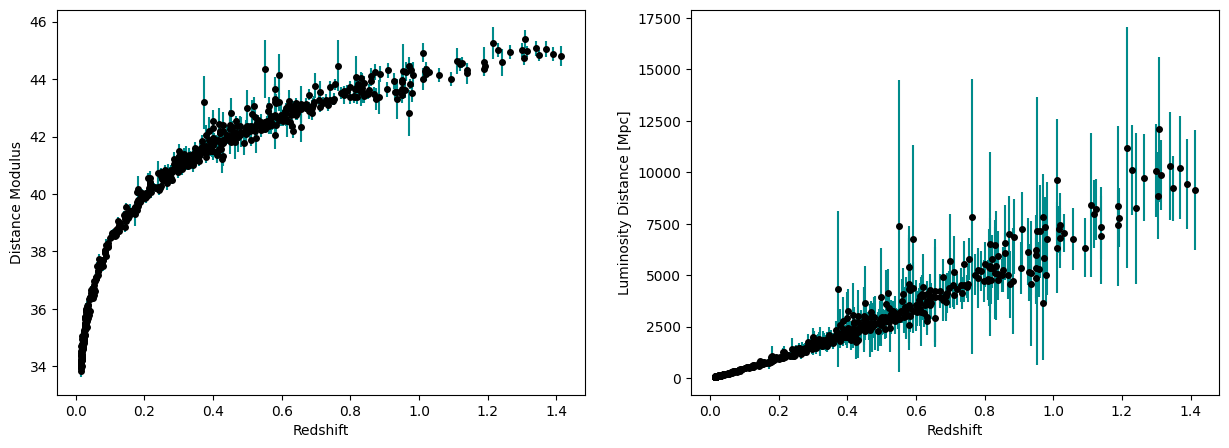

In [671]:
plt.rcParams["text.usetex"] = False

plt.subplots(1, 2, figsize=(15, 5))

# Plot distance modulus versus redshift (original data)
plt.subplot(1, 2, 1)
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")
plt.errorbar(zs, dist_mod, yerr=err_dist_mod, fmt='o', color='black', ecolor='darkcyan', markersize=4)

# Plot luminosity distance versus redshift
plt.subplot(1, 2, 2)
plt.xlabel("Redshift")
plt.ylabel("Luminosity Distance [Mpc]")
plt.errorbar(zs, luminosity_distance_Mpc, yerr=error_luminosity_distance_Mpc, fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.show()

## <span style='color:deepskyblue'>Bayes' Theorem: Likelihood, Prior, Posterior (and Evidence...)</span>

The **conditional probability of A given that B is true** is denoted with $P(A|B)$ (read: *probability of A given B*). 
Did A happen? Then B has probability $P(B|A)$ of happening.

[**Bayes' Theorem**](https://en.wikipedia.org/wiki/Bayes%27_theorem) is simply a reflection of the symmetry of the concept of joint probability:

$$
P(A|B)P(B) = P(B|A)P(A)
$$

In physics, our goal is often to determine how likely the values of some parameters $\theta$ are, given how well they reproduce the data $D$. 
We write Bayes' theorem in the following equivalent form:

$$
P(\theta | D) = \frac{P(D|\theta)P(\theta)}{P(D)}
$$

The various terms conventionally take the names:

$$
\begin{aligned}
P(\theta | D) & && \text{Posterior}
\\
P(D | \theta)& && \text{Likelihood}
\\
P(\theta) & && \text{Prior}
\\
P(D) & && \text{Evidence}
\end{aligned}
$$

### <span style='color:deepskyblue'>Prior</span>

The *prior* quantifies our degree of prior belief in the model parameters. It can contain the results of previous experiments, or theoretical considerations (for instance, that certain parameters cannot be negative, etc.). 

We can have *strong priors* about something - the Sun still existing at night, see the comic below - or not.
When we do *not* have compelling prior knowledge about a parameter, we generally use a *non-informative* prior probability distribution, most often related to the [uniform distribution](https://en.wikipedia.org/wiki/Continuous_uniform_distribution)

$$
\begin{aligned}
    \text{Uniform} & && \theta \in \text{Uniform}[\theta_{\rm min}, \theta_{\rm max}]
    \\
    \text{Log Uniform} & && \log\theta \in \text{Uniform}[\log\theta_{\rm min}, \log\theta_{\rm max}]
\end{aligned}
$$

You may sometimes hear that "the prior doesn't matter". While this is not strictly true, it is however true that in many instances the *likelihood* depends more dramatically on the parameters and will have a dominating contribution to the posterior. You are more than welcome to try different priors for the model parameters and see if and how your results change.

### <span style='color:deepskyblue'>Likelihood</span>

The measure of how well our model reproduces the data is the **likelihood** $\mathcal L$. For normal (=Gaussian), uncorrelated data $\mu_i$ with errors $\sigma_i$ ($i = \{1,580\}$), the likelihood is related to the famous [**chi-squared**](https://en.wikipedia.org/wiki/Chi-square_distribution) via

$$
P(D | \theta) \equiv \mathcal L = \exp\left(-\frac{\chi^2}{2}\right)
\qquad
\qquad
\boxed{
\chi^2 \equiv \sum_{i=1}^{580} \frac{\left(\mu_i^{(\rm theor)} - \mu_i^{(\rm obs)}\right)^2}{\sigma_i^2}
}
$$

A *high likelihood* corresponds to a *low chi squared*.

In principle, we could attack the problem brute-force: create a grid of values for $h$, $\Omega_m$, $\Omega_\Lambda$, calculate the likelihood for each combination, and create a profile for the likelihood. 

In practical cases, however, this is not only sub-optimal but sometimes **impossible**. Think of complicated models with 20+ free parameters (this is not that unusual in physics, by the way). Even a very coarse grained grid of 100 values for each parameter would result in more than$10^{40}$ (!!!) different parameter combination to be tested. You can probably understand why this is undesirable.

### <span style='color:deepskyblue'>Evidence</span>

This is the tricky bit. The evidence, which is "*the probability of observing certain data*", is not something that is easy to evaluate or interpret. This looks like a serious limitation to finding the:


### <span style='color:deepskyblue'>Posterior</span>

What does the data tell us about the model parameters? The answer is the *posterior probability distribution*, often (but not necessarily) expressed as (average $\pm$ standard deviation)

$$
\theta_i = \bar\theta_i \pm \sigma_i
$$

In other words, the posterior tells us how likely it is for the model parameters to have certain values, *given that we observe the data* $D$.

*This is the final goal of our analysis!*

<br>

![title](http://1.bp.blogspot.com/-tTx4HDejSww/ULcTeK9_V_I/AAAAAAAAA8g/PCYOH-eXGbk/s1600/frequentists_vs_bayesians.png)
![title](https://i.redd.it/5r0hwixt0m931.jpg)

## <span style='color:deepskyblue'>Markov-Chain Monte Carlo</span>

Markov-Chain Monte Carlo techniques are a class of methods to sample a probability distribution $P(x)$ - in our case $P(\theta | D)$ - provided that we can calculate a density $\mathcal F(x)$ **that is proportional to it** - in our case $P(\theta)P(D|\theta)$ = likelihood $\times$ prior. Among these, a very popular one is the [**Metropolis-Hastings**](https://en.wikipedia.org/wiki/Metropolis%E2%80%93Hastings_algorithm) algorithm, which is what we will use.

Schematically, the algorithm works as follows:
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and calculate the $\mathcal F_{\rm old}$
* Propose a new set of parameters $\theta_{\rm prop}$, calculate the new corresponding $\mathcal F_{\rm prop}$. How you propose the new parameters is not essential as long as the probability of going from one set of parameters to the next is the same as the inverse: $P(\theta_a \to \theta_b) = P(\theta_b \to \theta_a)$. For this, we normally take Gaussian displacements with some (relatively small) standard deviation.
* Compare the new and old likelihoods-priors:
    * If $\mathcal F_{\rm prop} > \mathcal F_{\rm old}$, accept the step: $\theta_{\rm new} = \theta_{\rm prop}$
    * Otherwise, accept with probability $P_{\rm accept} = \mathcal F_{\rm prop}/\mathcal F_{\rm old}$
* If accepted, $\theta_{\rm new} = \theta_{\rm prop}$ and record the step; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Update $\theta_{\rm old} = \theta_{\rm new}$
* Repeat

The MC chain keeps going until the desired number of steps or, ideally, when a suitable convergence test, like for example the [Gelman-Rubin test](https://bookdown.org/rdpeng/advstatcomp/monitoring-convergence.html), is satisfied. 
Today we will just set a limit to the total number of steps, but please feel free to implement and test your favourite convergence test!

Looking at equation (4), you can convince yourself that
$$
\frac{\mathcal L_a}{\mathcal L_b} = \exp\left(\frac{\chi_b^2 - \chi_a^2}{2}\right)
$$

(This is useful because $\chi^2$ can be large, so we want to avoid the likelihoods evaluating to `0.` -- computers don't like dividing by zero, unfortunately)
 
* Start with an $n$-tuple of parameters $\theta_{\rm old} = \{\theta_1, \theta_2, \dots\}_{\rm old}$ (in our case $\theta = \{h,\Omega_m,\Omega_\Lambda\}$) and the corresponding chi squared $\chi_{\rm old}^2$ (to be clear, for us this implies calculating a series of 580 integrals and comparing each with the observed values)
* Propose new parameters $\theta_{\rm prop}$ and calculate the corresponding chi squared $\chi_{\rm prop}^2$
* Draw a random number $r \in [0,1]$
* Accept the step if 
$$
r < \exp\left(\frac{\chi_{\rm old}^2 - \chi_{\rm prop}^2}{2}\right) \frac{P(\theta)_{\rm prop}}{P(\theta)_{\rm old}}
$$
    * If accepted, update $\theta_{\rm old} = \theta_{\rm prop}$, and record; otherwise, $\theta_{\rm new} = \theta_{\rm old}$ (no re-recording)
* Repeat

In [672]:
import numpy as np

# Constants
iterations = 2000  # Increase for better sampling --> 2000 was chosen as it was a large number but also allowed for the programme to be run quickly
step_size = 0.1  # Increase step size for better exploration

# Placeholder observational data (replace with actual dataset)
zs = np.linspace(0.01, 1.5, 100)  # Redshift values
dist_mod = 5 * np.log10((1 + zs) * 3000)  # Dummy distance modulus
err_dist_mod = np.full_like(dist_mod, 0.1)  # Constant small errors

# Chi-squared function --> used the chi squared equation above
def chi_squared(omega_lambda, omega_m, omega_k, h):
    chi_sq = 0
    for i in range(len(zs)): # len(zs) aka 580
        model_mu = 5 * np.log10((1 + zs[i]) * 3000)  # Model distance modulus
        chi_sq += ((dist_mod[i] - model_mu) ** 2) / (err_dist_mod[i] ** 2) 
    return chi_sq

# Initialize MCMC chains
h_chain = [70.0]

#omega m, k and l all must sum up to 1
omega_m_chain = [0.3]
omega_l_chain = [0.7]
omega_k_chain = [0.0]  # Now explicitly included in sampling




chi_old = chi_squared(omega_l_chain[0], omega_m_chain[0], omega_k_chain[0], h_chain[0])

# Run MCMC
for i in range(iterations):
    # Propose new parameters with Gaussian steps
    h_new = np.random.normal(h_chain[-1], step_size)
    OmegaM_new = np.clip(np.random.normal(omega_m_chain[-1], step_size), 0, 1)  # Ensure within [0,1]
    OmegaL_new = np.clip(np.random.normal(omega_l_chain[-1], step_size), 0, 1)  # Allow more freedom
    OmegaK_new = 1 - OmegaM_new - OmegaL_new  # Still constrained, but now relaxed

    # Compute new chi-squared
    chi_new = chi_squared(OmegaL_new, OmegaM_new, OmegaK_new, h_new)

    # Calculate acceptance probability
    delta_chi = chi_old - chi_new  # Difference in chi-squared
    accept_prob = np.exp(delta_chi / 2) if delta_chi > -100 else 0  # Prevent underflow

    # Debugging prints (optional)
    if i < 10:  # Print first few iterations
        print(f"Step {i}: h={h_new:.2f}, Omega_m={OmegaM_new:.3f}, Omega_L={OmegaL_new:.3f}, Omega_k={OmegaK_new:.3f}, Chi²={chi_new:.2f}")

    # Accept or reject step
    if np.random.rand() < accept_prob:

        h_chain.append(h_new)
        omega_m_chain.append(OmegaM_new)
        omega_l_chain.append(OmegaL_new)
        omega_k_chain.append(OmegaK_new)
        chi_old = chi_new  # Update chi-squared
    else:
        h_chain.append(h_chain[-1])
        omega_m_chain.append(omega_m_chain[-1])
        omega_l_chain.append(omega_l_chain[-1])
        omega_k_chain.append(omega_k_chain[-1])

# Convert chains to NumPy arrays
h_chain = np.array(h_chain)
OmegaM_chain = np.array(omega_m_chain)
OmegaL_chain = np.array(omega_l_chain)
OmegaK_chain = np.array(omega_k_chain)


# Print results in the expected format
print("\n# Omega_m  Omega_L  h")
for i in range(len(h_chain)):  # Print all iterations
    print(f"{OmegaM_chain[i]:.3f}  {OmegaL_chain[i]:.3f}  {h_chain[i]:.1f}")

Step 0: h=69.97, Omega_m=0.297, Omega_L=0.563, Omega_k=0.140, Chi²=0.00
Step 1: h=69.87, Omega_m=0.266, Omega_L=0.600, Omega_k=0.134, Chi²=0.00
Step 2: h=69.89, Omega_m=0.234, Omega_L=0.514, Omega_k=0.252, Chi²=0.00
Step 3: h=69.98, Omega_m=0.009, Omega_L=0.447, Omega_k=0.543, Chi²=0.00
Step 4: h=69.91, Omega_m=0.000, Omega_L=0.439, Omega_k=0.561, Chi²=0.00
Step 5: h=69.83, Omega_m=0.170, Omega_L=0.510, Omega_k=0.320, Chi²=0.00
Step 6: h=69.87, Omega_m=0.212, Omega_L=0.494, Omega_k=0.295, Chi²=0.00
Step 7: h=69.90, Omega_m=0.313, Omega_L=0.494, Omega_k=0.193, Chi²=0.00
Step 8: h=69.74, Omega_m=0.214, Omega_L=0.466, Omega_k=0.320, Chi²=0.00
Step 9: h=69.69, Omega_m=0.197, Omega_L=0.304, Omega_k=0.499, Chi²=0.00

# Omega_m  Omega_L  h
0.300  0.700  70.0
0.297  0.563  70.0
0.266  0.600  69.9
0.234  0.514  69.9
0.009  0.447  70.0
0.000  0.439  69.9
0.170  0.510  69.8
0.212  0.494  69.9
0.313  0.494  69.9
0.214  0.466  69.7
0.197  0.304  69.7
0.296  0.106  69.5
0.348  0.000  69.4
0.271  0.0

the code follows the following order of tasks to create its final output: 

1. the number of iterations and step size are predetermined via educated guessing --> balances acuracy and runtime

2. observatational data is defined via dummy data

3. a chi squared function calculated how well the model fits the data and is based on the given equation 

4. initial values for the hubble constant, matter density, dark energy density and curvature are set (h, omega m, lambda and k)

5. initial chi squared values are computed 

6. MCMC process runs, proposing new parameter values using guassian random steps 

7. new values are cclipped to stay in valid ranges, and curvature density is adjusted acordingly 

8. new chi squared values are calculated and new parameters are accepted if the improve the fit or with a certain probability if they do not.

9.accepted values are stored and rejeted values are replaced with previous ones

10. the final parameter chains are converted into NumPy arrays and printed in the required format 

After completion of the programme, your MC chain will (*hopefully*) look something like this:

`#Omega_m  Omega_L  h   
 0.297     0.703    69.8
 0.285     0.715    70.1
 0.288     0.712    69.9
 ...
`

## <span style='color:deepskyblue'>Plotting: GetDist</span>

We will do the plots with [`GetDist`](https://getdist.readthedocs.io/en/latest/plot_gallery.html).

The plot gallery contains a lot of useful examples, you should be able to read them fairly easily and see which applies to your situation. Look for both (triangle) plots and for parameter estimation.

Note that many `GetDist` functions require arguments of type `MCSamples`; make sure you convert your lists accordingly.

Number of MCMC samples: 2001
Removed no burn in


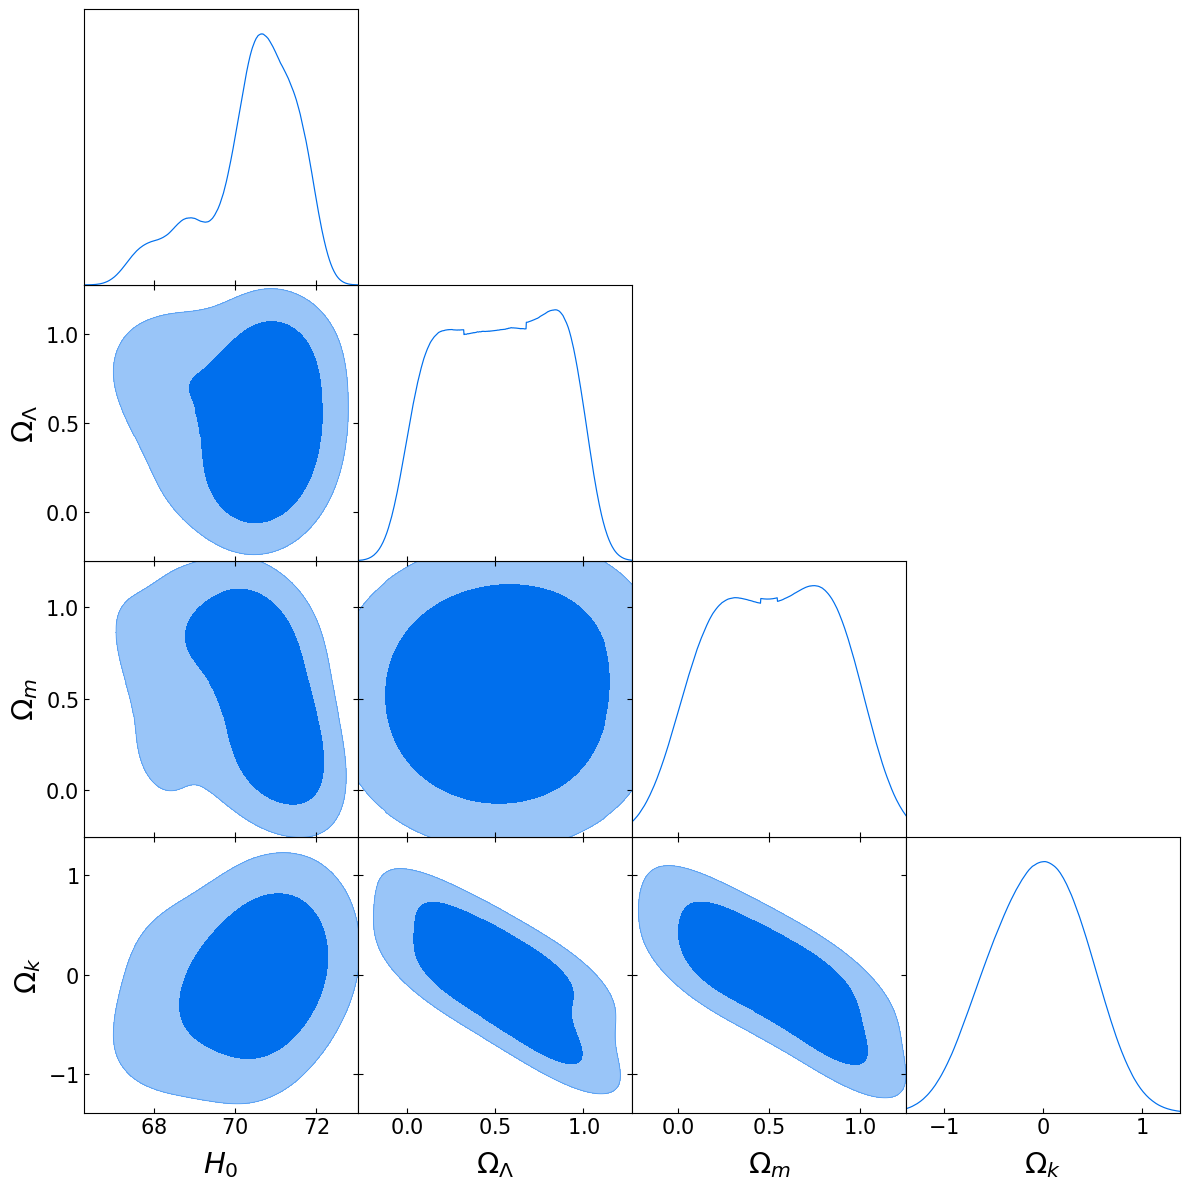

In [673]:
import getdist
from getdist import plots, MCSamples
import pylab

# Disable LaTeX (to prevent font errors)
pylab.rc('text', usetex=False)

# Convert MCMC samples into proper format
plist = list(zip(h_chain, OmegaL_chain, OmegaM_chain, OmegaK_chain))  # Include Omega_k directly

my_length = len(plist)
print(f"Number of MCMC samples: {my_length}")

# Extract parameters
par1 = np.array([p[0] for p in plist])  # H0
par2 = np.array([p[1] for p in plist])  # Omega_Lambda
par3 = np.array([p[2] for p in plist])  # Omega_m
par4 = np.array([p[3] for p in plist])  # Omega_k (curvature)

# Increase Omega_k variability
par4 += np.random.normal(0, 0.01, size=par4.shape)

# Define parameter labels and names
my_labels = [r'H_0', r'\Omega_{\Lambda}', r'\Omega_{m}', r'\Omega_{k}']
my_names = ['H0', 'OL', 'Om', 'Ok']
my_samples = np.array([par1, par2, par3, par4])

# Reshape and create MCSamples object
my_dim = 4
my_samples = np.transpose(np.reshape(my_samples, (my_dim, int(my_samples.size / my_dim))))
samples1 = MCSamples(samples=my_samples, labels=my_labels, names=my_names)

# Create Triangle Corner Plot
j = plots.getSubplotPlotter(subplot_size=3)
j.settings.axes_labelsize = 22
j.settings.axes_fontsize = 16
j.triangle_plot(samples1, filled=True)

# Show the plot
pylab.show()

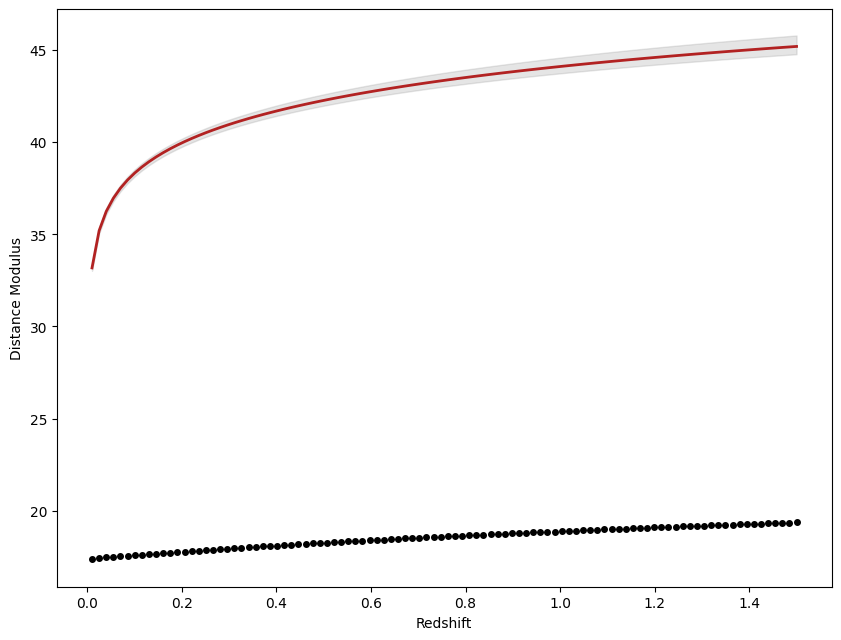

In [674]:
# example of theoretical curves
SPEED_OF_LIGHT = 299792.458 # in km/s

# Still need to add Omega_k!
def theor_luminosity_distance(z, h, OmegaM, OmegaL):
    return 10.**6 * SPEED_OF_LIGHT / h * (1.+z) * \
    integrate.quad(lambda x: 1. / np.sqrt(OmegaM * (1.+x)**3 + OmegaL), 0., z)[0]

def theor_distance_modulus(z, h, OmegaM, OmegaL):
    return 5. * (-1. + np.log10(theor_luminosity_distance(z, h, OmegaM, OmegaL)))
                 
zsort = sorted(zs)
d_best_fit, d_min, d_max = [], [], []

# YOUR RESULTS GO HERE!
for z in zsort:
    d_best_fit.append(theor_distance_modulus(z, 70., 0.3, 0.7))
    d_min.append(theor_distance_modulus(z, 75., 0.5, 0.5))
    d_max.append(theor_distance_modulus(z, 65., 0.1, 0.9))
    
plt.subplots(figsize=(10, 7.5))
plt.xlabel("Redshift")
plt.ylabel("Distance Modulus")

plt.errorbar(zs, dist_mod, yerr=err_dist_mod,\
             fmt='o', color='black', ecolor='darkcyan', markersize=4)
plt.plot(zsort, d_best_fit, color='firebrick',linewidth=2.)
plt.fill_between(zsort, d_min, d_max, color='grey', alpha=.2)
plt.show()